In [1]:
from pathlib import Path

from arcadia_microscopy_tools import MicroscopyImage

In [2]:
# Locate the sample ND2 file in the test data directory
sample_data_directory = Path("../../src/arcadia_microscopy_tools/tests/data")
nd2_path = next(sample_data_directory.glob("example-pbmc.nd2"))
print("ND2 file:", nd2_path)

# Load the microscopy image
image = MicroscopyImage.from_nd2_path(nd2_path)
image  # Display the image object representation

ND2 file: ../../src/arcadia_microscopy_tools/tests/data/example-pbmc.nd2


MicroscopyImage(sizes={'C': 4, 'Y': 256, 'X': 256}, channels=['BRIGHTFIELD', 'DAPI', 'FITC', 'TRITC'], intensities=[2049, 1977, 1894, ..., 778, 810, 808], dtype=uint16)

In [3]:
from arcadia_microscopy_tools import ImageOperation, Pipeline
from arcadia_microscopy_tools.operations import rescale_by_percentile

preprocessing_pipeline = Pipeline(
    [ImageOperation(rescale_by_percentile, percentile_range=(0.1, 99.9))]
)

channel = image.channels[0]  # BRIGHTFIELD

preprocessed = image.apply_pipeline(preprocessing_pipeline, channel=channel)

In [6]:
from arcadia_microscopy_tools.model import SegmentationModel

model = SegmentationModel()
mask = model.segment(preprocessed.astype(float))

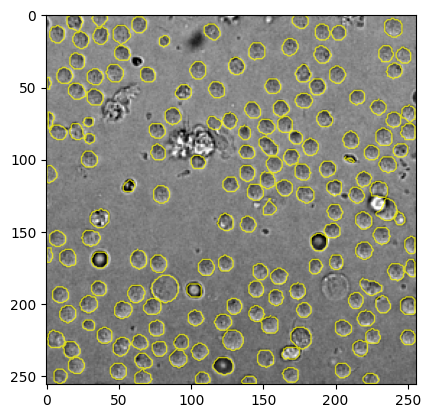

In [7]:
import matplotlib.pyplot as plt
from cellpose.utils import outlines_list

# Get cell outlines as list of (x, y) coordinates
cell_outlines = outlines_list(mask)

# Create figure
fig, ax = plt.subplots()

ax.imshow(preprocessed, cmap="gray")
for coords_xy in cell_outlines:
    ax.plot(coords_xy[:, 0], coords_xy[:, 1], color="#ffff00", lw=1, alpha=0.7)